In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# !gdown --id 1s4u84am5eq99JPxw6wRdrkfnxzKIUWkk

In [6]:
# !unzip /content/empowerview_files.zip 

In [7]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Python 3.10.4\python.exe -m pip install --upgrade pip' command.


In [8]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
import os

import csv
import numpy as np
import pandas as pd

import tensorflow as tf

mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions


def recolor_image(image):
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def recolor_image_back(image):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def draw_face_landmarks(image, face_landmarks):
    mp_drawing.draw_landmarks(image, face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )

def draw_right_hand_landmarks(image, right_hand_landmarks):
    mp_drawing.draw_landmarks(image, right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )

def draw_left_hand_landmarks(image, left_hand_landmarks):
    mp_drawing.draw_landmarks(image, left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

def draw_pose_landmarks(image, pose_landmarks):
    mp_drawing.draw_landmarks(image, pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

def process_image(holistic, image):
    results = holistic.process(image)
    face_landmarks = results.face_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    left_hand_landmarks = results.left_hand_landmarks
    pose_landmarks = results.pose_landmarks
    return results, face_landmarks, right_hand_landmarks, left_hand_landmarks, pose_landmarks

In [9]:
import time

def load_classifyer():
    # import os
    # current_dir = os.path.dirname(os.path.abspath(''))
    # path = current_dir+'\DS_EmpowerView\holistic_folder\saved_models\weights_model_1.hdf5'
    # model = tf.keras.models.load_model('/saved_models/classy_model_1')
    model = tf.keras.models.load_model('D:\Empower View\DS_EmpowerView\holistic_folder\saved_models\classy_model_1.h5')
    # model.load_weights(path)
    return model

def create_train_set_csv(file_name,landmarks):
        with open(file_name, mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(landmarks)

def process_camera(holistic, output_file=0, class_name=None, input_file=0):

    if not output_file: # in case there is no specific given output file
                    output_file = input_file.replace('.mp4', '.csv')

    if input_file:
        current_dir = os.path.dirname(os.path.abspath(__file__))
        input_file = os.path.join(current_dir, 'videos/'+input_file)
    cap = cv2.VideoCapture(input_file)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = recolor_image(frame) # Recolor Feed
        results, face_landmarks, right_hand_landmarks, left_hand_landmarks, pose_landmarks = process_image(holistic, image) # Make Detections
        image = recolor_image_back(image) # Recolor image back to BGR for rendering

        draw_face_landmarks(image, face_landmarks) # 1. Draw face landmarks
        draw_right_hand_landmarks(image, right_hand_landmarks) # 2. Right hand
        draw_left_hand_landmarks(image, left_hand_landmarks) # 3. Left Hand
        draw_pose_landmarks(image, pose_landmarks) # 4. Pose Detections

        if class_name or 1:
            # Export coordinates
            try:
                # Extract Pose landmarks
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[round(landmark.x, 8), round(landmark.y, 8), round(landmark.z, 8), round(landmark.visibility, 8)] for landmark in pose]).flatten())
                # Extract Face landmarks
                face = results.face_landmarks.landmark
                face_row = list(np.array([[round(landmark.x, 8), round(landmark.y, 8), round(landmark.z, 8), round(landmark.visibility, 8)] for landmark in face]).flatten())
                # Concate rows
                row = pose_row+face_row
                # Append class name
                if class_name:
                     row.insert(0, class_name)

                # Append timestamp
                ts = time.time()
                row.insert(0, ts)

                # Export to CSV
                current_dir = os.path.dirname(os.path.abspath(__file__))
                output_dir = os.path.join(current_dir, 'output_csv_directory')
                if not os.path.exists(output_dir): # if the folder does not exist create it
                    os.mkdir(output_dir)

                output_file_path = output_dir + '/' + output_file
                if not os.path.exists(output_file_path): # if the file does not exist create it
                    num_coords = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark)
                    landmarks = []
                    landmarks += ['timestamp']
                    if class_name:
                         landmarks += ['class']

                    for val in range(1, num_coords+1):
                        landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]
                    create_train_set_csv(output_file_path,landmarks)
                
                with open(output_file_path, mode='a', newline='') as f: # append the coordinates to the csv
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)
            except:
                pass

        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'): # press 'q' to exist
            break

    # cap.release()
    cv2.destroyAllWindows()
    return results

def process_video_to_coordinates_csv(output_file=0, class_name=None, input_file=0):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        process_camera(holistic, output_file, class_name, input_file)

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train_set4.csv')
X = df.drop('timestamp', axis=1)
X = X.drop('class', axis=1) # features
y = df['class'] # target value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [66]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# pipelines = {
#     'lr':make_pipeline(StandardScaler(), LogisticRegression()),
#     'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
#     'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
#     'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
# }

pipelines = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
}

fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle 

for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

rf 1.0


In [67]:
model = fit_models['rf']
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )

        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
        # Export coordinates
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row
            
#             # Append class name 
#             row.insert(0, class_name)
            
#             # Export to CSV
#             with open('coords.csv', mode='a', newline='') as f:
#                 csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#                 csv_writer.writerow(row) 

            # Make Detections
            X = pd.DataFrame([row])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, body_language_prob)
            
            # Grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [640,480]).astype(int))
            
            cv2.rectangle(image, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(body_language_class)*20, coords[1]-30), 
                          (245, 117, 16), -1)
            cv2.putText(image, body_language_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except Exception as e:
            print("Error:", e)
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [60]:
!pip install opencv-python-headless

^C


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Python 3.10.4\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'D:\Python 3.10.4\python.exe -m pip install --upgrade pip' command.


     --------------------------------------- 38.1/38.1 MB 12.6 MB/s eta 0:00:00


In [110]:
import cv2
import mediapipe as mp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Load the MediaPipe Holistic model
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

# Load the Random Forest model
rf_model = fit_models['rf']

def classify_gesture(video_path):
    # Load the video
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Choose a random frame
    frame_number = np.random.randint(frame_count)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()

    # Process the frame through the MediaPipe Holistic model
    results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Extract the coordinates
    try:
        coords = []
        for landmark in results.pose_landmarks.landmark:
            coords.append([landmark.x, landmark.y, landmark.z])
        for landmark in results.left_hand_landmarks.landmark:
            coords.append([landmark.x, landmark.y, landmark.z])
        for landmark in results.right_hand_landmarks.landmark:
            coords.append([landmark.x, landmark.y, landmark.z])
        for landmark in results.face_landmarks.landmark:
            coords.append([landmark.x, landmark.y, landmark.z])
    except:
        pass

    # Show the frame
    cv2.imshow('frame', frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print(coords)

    # Plot the coordinates in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [coord[0] for coord in coords]
    ys = [coord[1] for coord in coords]
    zs = [coord[2] for coord in coords]
    ax.scatter(xs, ys, zs)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

    # Classify the gesture using the Random Forest model
    # gesture = rf_model.predict([coords])[0]
    # print('The gesture is:', gesture)

    plt.show()

[[0.5092748999595642, 0.3795253038406372, -0.9909076690673828], [0.5330968499183655, 0.32859957218170166, -0.9536987543106079], [0.5460869073867798, 0.33367276191711426, -0.9539204835891724], [0.5570425987243652, 0.3383902311325073, -0.9540241360664368], [0.4963460862636566, 0.3152121305465698, -0.9571922421455383], [0.48110586404800415, 0.31212615966796875, -0.9571807980537415], [0.4676993489265442, 0.31062817573547363, -0.9576715230941772], [0.5762621164321899, 0.3681914806365967, -0.6521208882331848], [0.44957026839256287, 0.33767127990722656, -0.6633488535881042], [0.5275295972824097, 0.44428858160972595, -0.8728241920471191], [0.4777764678001404, 0.43807634711265564, -0.8761942982673645], [0.6502695679664612, 0.6505190134048462, -0.39894235134124756], [0.3558381199836731, 0.663316011428833, -0.4478323459625244], [0.7076411247253418, 1.0177369117736816, -0.33675357699394226], [0.31605446338653564, 1.0354681015014648, -0.3606344163417816], [0.7463904023170471, 1.3269294500350952, -0

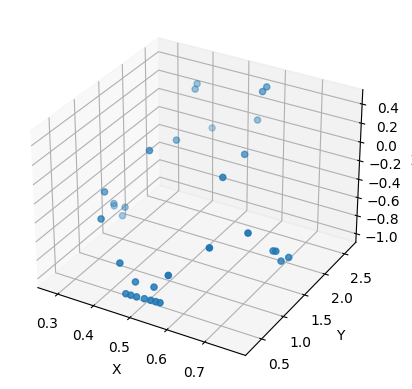

In [111]:
classify_gesture('video1.mp4')

In [1]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

# getting an image and plotting the image with the coordinates from the holistic
def show_img_coords(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    mp_holistic, mp_drawing = mp.solutions.holistic, mp.solutions.drawing_utils
    with mp_holistic.Holistic(static_image_mode=True) as holistic:
        results = holistic.process(image)
        fig, ax = plt.subplots(figsize=(5, 2))
        ax.imshow(image)
        for name, color in [('face_landmarks', 'r'), ('pose_landmarks', 'b'), ('left_hand_landmarks', 'g'), ('right_hand_landmarks', 'm')]:
            landmarks = getattr(results, name, None)
            if landmarks:
                for landmark in landmarks.landmark:
                    x, y = int(landmark.x * width), int(landmark.y * height)
                    if 0 <= x < width and 0 <= y < height:
                        ax.plot(x, y, color + 'o')
        plt.show()

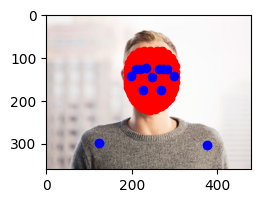

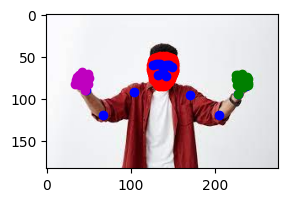

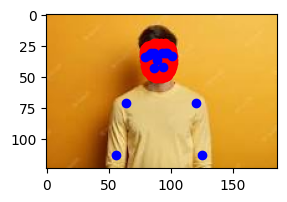

In [2]:
show_img_coords('happy_1.jpg')
show_img_coords('happy_2.jpg')

show_img_coords('sad_1.jpg')

In [7]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp
import pandas as pd
import numpy as np

# getting an image and plotting the image with the coordinates from the holistic


def show_img_coords(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    mp_holistic, mp_drawing = mp.solutions.holistic, mp.solutions.drawing_utils
    with mp_holistic.Holistic(static_image_mode=True) as holistic:
        results = holistic.process(image)

        # Define a function to extract landmarks
        def extract_landmarks(landmarks):
            if landmarks:
                return list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks.landmark]).flatten())
            else:
                return [0] * 84

        # Extract landmarks for each body part
        face_row = extract_landmarks(results.face_landmarks)
        left_hand_row = extract_landmarks(results.left_hand_landmarks)
        right_hand_row = extract_landmarks(results.right_hand_landmarks)
        pose_row = extract_landmarks(results.pose_landmarks)

        feature_vector = pose_row + face_row + left_hand_row + right_hand_row
        print("total number of coordinates:",len(feature_vector))


        # plot the coordinates
        row = face_row + pose_row
        row = feature_vector
        X = pd.DataFrame([row])

        x = X.iloc[0, ::4]
        y = X.iloc[0, 1::4]
        z = X.iloc[0, 2::4]

        print("shapes of x y z plots:",x.shape, y.shape, z.shape)

        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.scatter3D(x, z, y, cmap='Greens')
        ax.view_init(elev=0, azim=-90)

        ax.set_xlabel('X Axis')
        ax.set_ylabel('Z Axis')
        ax.set_zlabel('Y Axis')

        ax.invert_zaxis()

        plt.show()

        # plot the images with the coordinates
        fig, ax = plt.subplots(figsize=(6,4))
        ax.imshow(image)
        for name, color in [('face_landmarks', 'r'), ('pose_landmarks', 'b'), ('left_hand_landmarks', 'g'), ('right_hand_landmarks', 'm')]:
            landmarks = getattr(results, name, None)
            if landmarks:
                for landmark in landmarks.landmark:
                    x, y = int(landmark.x * width), int(landmark.y * height)
                    if 0 <= x < width and 0 <= y < height:
                        ax.plot(x, y, color + 'o')
        plt.show()

        print("====================================================================")

total number of coordinates: 2172
shapes of x y z plots: (543,) (543,) (543,)


C:\Users\omers\AppData\Local\Temp\ipykernel_21424\2219837963.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(x, z, y, cmap='Greens')


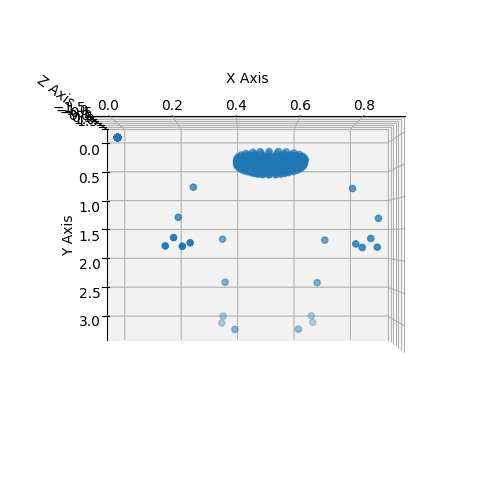

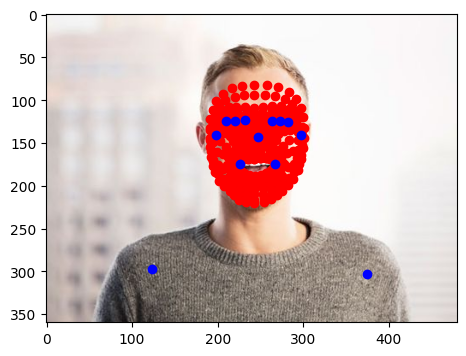

total number of coordinates: 2172
shapes of x y z plots: (543,) (543,) (543,)


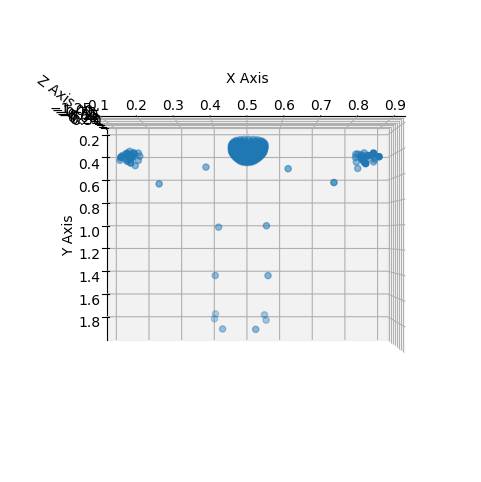

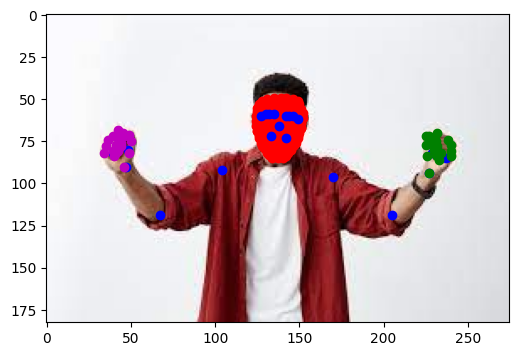

total number of coordinates: 2172
shapes of x y z plots: (543,) (543,) (543,)


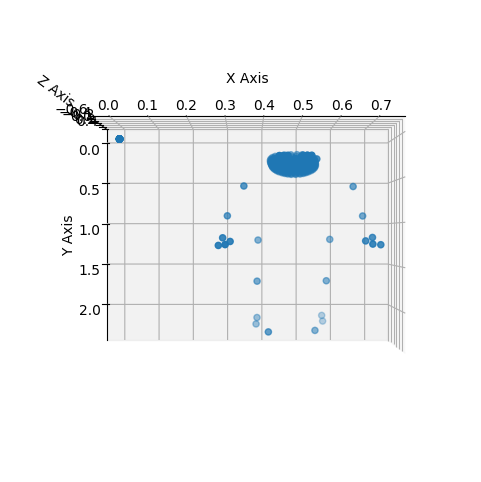

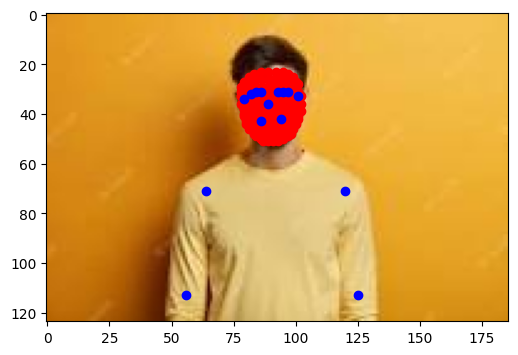

total number of coordinates: 2172
shapes of x y z plots: (543,) (543,) (543,)


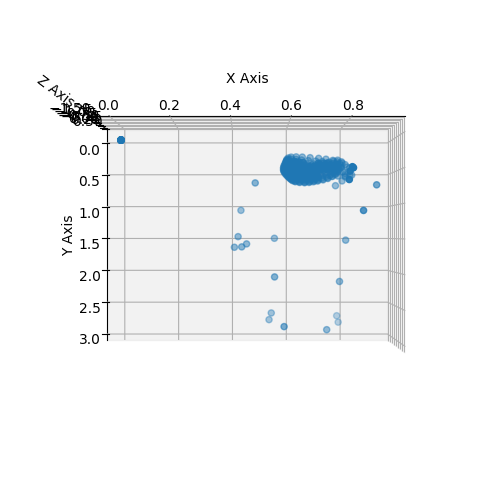

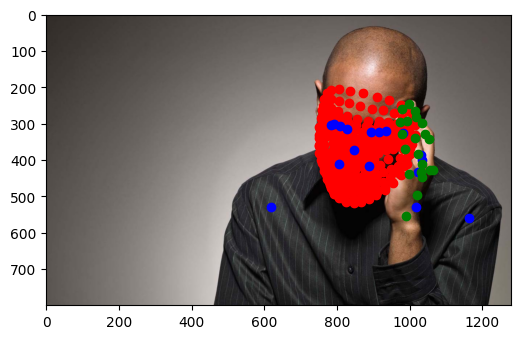

In [8]:
show_img_coords('happy_1.jpg')
show_img_coords('happy_2.jpg')

show_img_coords('sad_1.jpg')
show_img_coords('sad_2.jpg')

# print(counters)